# Lecture 17: Class demo

## Imports

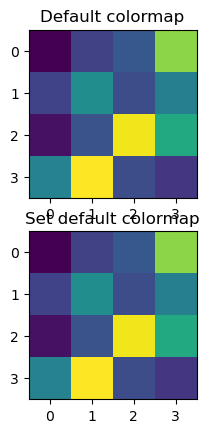

In [1]:
import os
import re
import string
import sys
import time

sys.path.append(os.path.join(os.path.abspath(".."), (".."), "code"))

from plotting_functions_unsup import *

import IPython
import numpy as np
import numpy.random as npr
import pandas as pd
from comat import CooccurrenceMatrix
from nltk.tokenize import sent_tokenize, word_tokenize
from preprocessing import MyPreprocessor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

DATA_DIR = os.path.join(os.path.abspath("../.."), "data/")

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kvarada/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Topic modeling 

**Why topic modeling?**

**Topic modeling introduction activity (~5 mins)**

- Consider the following documents. 

In [3]:
toy_df = pd.read_csv(DATA_DIR + "toy_clustering.csv")
toy_df

,text
0,famous fashion model
1,elegant fashion model
2,fashion model at famous probabilistic topic mo...
3,fresh elegant fashion model
4,famous elegant fashion model
5,probabilistic conference
6,creative probabilistic model
7,model diet apple kiwi nutrition
8,probabilistic model
9,kiwi health nutrition


**Discuss the following questions with your neighbour**
1. Suppose you are asked to cluster these documents manually. How many clusters would you identify?
2. What are the prominent words in each cluster? 
4. Are there documents which are a mixture of multiple clusters? 

Last week, we learned about clustering. Let's try K-Means clustering on this data with BOW representation: 

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(stop_words="english")
toy_X = vec.fit_transform(toy_df["text"])
toy_X

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 54 stored elements and shape (15, 16)>

In [5]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3) 

kmeans_bow = KMeans(n_clusters=3, random_state=42)
kmeans_bow.fit(toy_X)
kmeans_bow_labels = kmeans_bow.labels_
toy_df["bow_kmeans"] = kmeans_bow_labels
toy_df

,text,bow_kmeans
0,famous fashion model,2
1,elegant fashion model,2
2,fashion model at famous probabilistic topic mo...,2
3,fresh elegant fashion model,2
4,famous elegant fashion model,2
5,probabilistic conference,0
6,creative probabilistic model,0
7,model diet apple kiwi nutrition,1
8,probabilistic model,0
9,kiwi health nutrition,1


Do you see any problem here? 

<br><br><br><br>

### Topic modeling motivation

- K-Means clustering gives each document a *hard assignment*; each document belongs to exactly one cluster.
  
- But in reality, many documents are a mixture of topics.  
  - A news article might talk about *sports* and *politics*.  
  - A research paper might cover *machine learning* and *linguistics*.     

**Topic modeling: Input and output**

- Input
    - A large collection of documents
    - A value for the hyperparameter $K$ (e.g., $K = 3$)
- Output
    - For each topic, what words describe that topic?  
    - For each document, what topics are expressed by the document?

![](../../img/topic_modeling_output.png)

<!-- <center> -->
<!-- <img src="img/topic_modeling_output.png" height="800" width="800">  -->
<!-- </center> -->    

**Topic modeling: Some applications**

- Topic modeling is a great EDA tool to get a sense of what's going on in a large corpus. 
- Some examples
    - If you want to pull documents related to a particular lawsuit. 
    - You want to examine people's sentiment towards a particular candidate and/or political party and so you want to pull tweets or Facebook posts related to election.   

**Topic modeling examples**

**Topic modeling: Input**

![](../../img/TM_science_articles.png)

<!-- <center> -->
<!-- <img src="img/TM_science_articles.png" height="2000" width="2000">  -->
<!-- </center>     -->
    
Credit: [David Blei's presentation](http://www.cs.columbia.edu/~blei/talks/Blei_Science_2008.pdf)

**Topic modeling: output**

![](../../img/TM_topics.png)

<!-- <center> -->
<!-- <img src="img/TM_topics.png" height="900" width="900">  -->
<!-- </center>     -->


(Credit: [David Blei's presentation](http://www.cs.columbia.edu/~blei/talks/Blei_Science_2008.pdf))

**Topic modeling: output with interpretation**
- Assigning labels is a human thing. 

![](../../img/TM_topics_with_labels.png)

<!-- <center> -->
<!-- <img src="img/TM_topics_with_labels.png" height="800" width="800">  -->
<!-- </center>     -->

(Credit: [David Blei's presentation](http://www.cs.columbia.edu/~blei/talks/Blei_Science_2008.pdf))

**LDA topics in Yale Law Journal**

![](../../img/TM_yale_law_journal.png)

<!-- <center> -->
<!-- <img src="img/TM_yale_law_journal.png" height="1500" width="1500">  -->
<!-- </center>     -->

(Credit: [David Blei's paper](http://www.cs.columbia.edu/~blei/papers/Blei2012.pdf))

### LDA topics in social media

![](../../img/TM_health_topics_social_media.png)

<!-- <center> -->
<!-- <img src="img/TM_health_topics_social_media.png" height="1300" width="1300">  -->
<!-- </center> -->

(Credit: [Health topics in social media](https://journals.plos.org/plosone/article/figure?id=10.1371/journal.pone.0103408.g002))

In this lecture, I will demonstrate how to perform topic modeling using the **Latent Dirichlet Allocation** model implemented in `sklearn`. We won't delve into the inner workings of the model, as it falls outside the scope of this course. Instead, our objective is to understand how to apply it to your specific problems and comprehend the model's input and output.

### Topic modeling toy example

Let's work with a toy example. 

In [6]:
toy_df = pd.read_csv(DATA_DIR + "toy_lda_data.csv")
toy_df

,doc_id,text
0,1,famous fashion model
1,2,fashion model pattern
2,3,fashion model probabilistic topic model confer...
3,4,famous fashion model
4,5,fresh fashion model
5,6,famous fashion model
6,7,famous fashion model
7,8,famous fashion model
8,9,famous fashion model
9,10,creative fashion model


- Input to the LDA topic model is bag-of-words representation of text.
- Let's create bag-of-words representation of "text" column.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(stop_words="english")
toy_X = vec.fit_transform(toy_df["text"])
toy_X

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 124 stored elements and shape (39, 15)>

In [8]:
vocab = vec.get_feature_names_out() # vocabulary
vocab

array(['apple', 'conference', 'creative', 'famous', 'fashion', 'fresh',
       'health', 'hidden', 'kiwi', 'markov', 'model', 'nutrition',
       'pattern', 'probabilistic', 'topic'], dtype=object)

In [9]:
len(vocab)

15

Let's try to create a topic model with sklearn's `LatentDirichletAllocation`. 

In [10]:
from sklearn.decomposition import LatentDirichletAllocation

n_topics = 3 # number of topics
lda = LatentDirichletAllocation(
    n_components=n_topics, learning_method="batch", max_iter=10, random_state=0
)
lda.fit(toy_X) 
document_topics = lda.transform(toy_X)

- Once we have a fitted model we can get the word-topic association and document-topic association  
- Word-topic association
    - `lda.components_` gives us the weights associated with each word for each topic. In other words, it tells us which word is important for which topic. 
- Document-topic association    
    - Calling transform on the data gives us document-topic association. 

In [11]:
lda.components_

array([[ 0.33380754,  3.31038074,  0.33476534,  0.33397112,  0.36695134,
         0.33439238,  0.33381373,  0.35771821,  0.33380649,  0.35771821,
        17.78521263,  0.33380761,  0.3573886 , 17.31634363, 15.32791718],
       [ 8.33224516,  0.33400489,  2.2173627 ,  0.33411086,  0.33732465,
         3.28753559,  5.33223002,  0.33435326,  9.33224759,  0.33435326,
         0.33797555,  8.3322447 ,  0.33462759,  0.33440682,  0.33425967],
       [ 0.3339473 ,  0.35561437,  0.44787197,  8.33191802, 14.29572402,
         0.37807203,  0.33395626,  1.30792853,  0.33394593,  1.30792853,
        13.87681182,  0.33394769,  2.30798381,  0.34924955,  0.33782315]])

In [12]:
print("lda.components_.shape: {}".format(lda.components_.shape))

lda.components_.shape: (3, 15)


In [13]:
import plotly.express as px
plot_lda_w_vectors(lda.components_, ['topic 0', 'topic 1', 'topic 2'], vocab, width=800, height=600)

Let's look at the words with highest weights for each topic more systematically. 

In [14]:
np.argsort(lda.components_, axis=1)

array([[ 8,  0, 11,  6,  3,  5,  2, 12,  7,  9,  4,  1, 14, 13, 10],
       [ 1,  3, 14,  7,  9, 13, 12,  4, 10,  2,  5,  6, 11,  0,  8],
       [ 8,  0, 11,  6, 14, 13,  1,  5,  2,  9,  7, 12,  3, 10,  4]])

In [15]:
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
feature_names = np.array(vec.get_feature_names_out())

In [16]:
import mglearn

mglearn.tools.print_topics(
    topics=range(3),
    feature_names=feature_names,
    sorting=sorting,
    topics_per_chunk=5,
    n_words=10,
)

topic 0       topic 1       topic 2       
--------      --------      --------      
model         kiwi          fashion       
probabilistic apple         model         
topic         nutrition     famous        
conference    health        pattern       
fashion       fresh         hidden        
markov        creative      markov        
hidden        model         creative      
pattern       fashion       fresh         
creative      pattern       conference    
fresh         probabilistic probabilistic 




- Here is how we can interpret the topics
    - Topic 0 $\rightarrow$ ML modeling 
    - Topic 1 $\rightarrow$ fruit and nutrition
    - Topic 2 $\rightarrow$ fashion

Let's look at distribution of topics for a document

In [17]:
toy_df.iloc[0]['text']

'famous fashion model'

In [18]:
document_topics[0]

array([0.08791477, 0.08338644, 0.82869879])

This document is made up of 
- ~83% topic 2
- ~9% topic 0 
- ~8% topic 1.  

### Topic modeling pipeline 

- Above we worked with toy data. In the real world, we usually need to preprocess the data before passing it to LDA. 
- Here are typical steps if you want to carry out topic modeling on real-world data. 
    - Preprocess your corpus. 
    - Train LDA.
    - Interpret your topics.     

**Data**

In [19]:
import wikipedia

queries = [
    "Artificial Intelligence",
    "unsupervised learning",
    "Supreme Court of Canada",
    "Peace, Order, and Good Government",
    "Canadian constitutional law",
    "ice hockey",
]
wiki_dict = {"wiki query": [], "text": []}
for i in range(len(queries)):
    wiki_dict["text"].append(wikipedia.page(queries[i]).content)
    wiki_dict["wiki query"].append(queries[i])

wiki_df = pd.DataFrame(wiki_dict)
wiki_df

,wiki query,text
0,Artificial Intelligence,Artificial intelligence (AI) is the capability...
1,unsupervised learning,"In machine learning, supervised learning (SL) ..."
2,Supreme Court of Canada,The Supreme Court of Canada (SCC; French: Cour...
3,"Peace, Order, and Good Government","In many Commonwealth jurisdictions, the phrase..."
4,Canadian constitutional law,Canadian constitutional law (French: droit con...
5,ice hockey,Ice hockey (or simply hockey in North America)...


**Preprocessing the corpus**

- **Preprocessing is crucial!**
- Tokenization, converting text to lower case
- Removing punctuation and stopwords
- Discarding words with length < threshold or word frequency < threshold        
- Possibly lemmatization: Consider the lemmas instead of inflected forms. 
- Depending upon your application, restrict to specific part of speech;
    * For example, only consider nouns, verbs, and adjectives

Check out [AppendixC](../../notes/AppendixC.ipynb) for basic preprocessing in NLP. 

We'll use [`spaCy`](https://spacy.io/) for preprocessing. Check out available token attributes [here](https://spacy.io/usage/rule-based-matching#adding-patterns-attributes). 

Even though you have `spacy` installed, you will need to install the following pre-trained `spacy` model in the course environment. 

```python -m spacy download en_core_web_md```

In [20]:
import spacy

nlp = spacy.load("en_core_web_md", disable=["parser", "ner"])

In [21]:
def preprocess(
    doc,
    min_token_len=2,
    irrelevant_pos=["ADV", "PRON", "CCONJ", "PUNCT", "PART", "DET", "ADP", "SPACE"],
):
    """
    Given text, min_token_len, and irrelevant_pos carry out preprocessing of the text
    and return a preprocessed string.

    Parameters
    -------------
    doc : (spaCy doc object)
        the spacy doc object of the text
    min_token_len : (int)
        min_token_length required
    irrelevant_pos : (list)
        a list of irrelevant pos tags

    Returns
    -------------
    (str) the preprocessed text
    """

    clean_text = []

    for token in doc:
        if (
            token.is_stop == False  # Check if it's not a stopword
            and len(token) > min_token_len  # Check if the word meets minimum threshold
            and token.pos_ not in irrelevant_pos
        ):  # Check if the POS is in the acceptable POS tags
            lemma = token.lemma_  # Take the lemma of the word
            clean_text.append(lemma.lower())
    return " ".join(clean_text)

In [22]:
wiki_df["text_pp"] = [preprocess(text) for text in nlp.pipe(wiki_df["text"])]

In [23]:
wiki_df

,wiki query,text,text_pp
0,Artificial Intelligence,Artificial intelligence (AI) is the capability...,artificial intelligence capability computation...
1,unsupervised learning,"In machine learning, supervised learning (SL) ...",machine learning supervised learning type mach...
2,Supreme Court of Canada,The Supreme Court of Canada (SCC; French: Cour...,supreme court canada scc french cour suprême c...
3,"Peace, Order, and Good Government","In many Commonwealth jurisdictions, the phrase...",commonwealth jurisdiction phrase peace order g...
4,Canadian constitutional law,Canadian constitutional law (French: droit con...,canadian constitutional law french droit const...
5,ice hockey,Ice hockey (or simply hockey in North America)...,ice hockey hockey north america team sport pla...


In [24]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(stop_words='english')
X = vec.fit_transform(wiki_df["text_pp"])

In [25]:
from sklearn.decomposition import LatentDirichletAllocation

n_topics = 3
lda = LatentDirichletAllocation(
    n_components=n_topics, learning_method="batch", max_iter=10, random_state=0
)
document_topics = lda.fit_transform(X)

In [26]:
print("lda.components_.shape: {}".format(lda.components_.shape))

lda.components_.shape: (3, 4095)


In [27]:
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
feature_names = np.array(vec.get_feature_names_out())

In [28]:
import mglearn

mglearn.tools.print_topics(
    topics=range(3),
    feature_names=feature_names,
    sorting=sorting,
    topics_per_chunk=5,
    n_words=10,
)

topic 0       topic 1       topic 2       
--------      --------      --------      
displaystyle  court         hockey        
algorithm     intelligence  player        
learning      problem       team          
law           artificial    ice           
function      machine       league        
training      human         play          
learn         use           puck          
provincial    decision      game          
court         include       penalty       
federal       learning      canada        




Check out some recent topic modeling tools
- [Topic2Vec](https://top2vec.readthedocs.io/en/stable/Top2Vec.html)
- [BERTopic](https://maartengr.github.io/BERTopic/index.html)

<br><br><br><br>

## Text representations and word embeddings

### Motivation 

Do large language models such as ChatGPT *understand* your questions to some extent and provide useful responses?

What would it take for a machine to "understand" language?  
A first step is to find a way to represent text, numbers that capture meaning.

So far, we have seen **bag-of-words (BoW)** representation using `CountVectorizer` in `sklearn`.  

Let's quickly recall what that looks like.

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

docs = ["This movie is amazing", "This movie is terrible"]
vec = CountVectorizer()
pd.DataFrame(vec.fit_transform(docs).toarray(), columns=vec.get_feature_names_out())

,amazing,is,movie,terrible,this
0,1,1,1,0,1
1,0,1,1,1,1


What are some limitations of Bag-of-Words? 

- Sparse, high-dimensional vectors

- Only capture word frequency

- Ignore word order and context

- Do not put similar words (e.g., happy, joyful) close together

BoW represents documents, but it treats each word as an independent token, 
there's no notion of word meaning or relationships between words.

In this part of the lecture, we are going to go one step back and talk about word representations. Why care about word representations?

- Words are the basic building blocks of language; the smallest units that carry meaning.

- To truly understand a document, a model must first understand the meaning of the words in it.
- If we can represent each word in a way that captures its meaning,
then we can combine these representations to understand larger pieces of text (sentences, paragraphs, documents).
- In other words, to represent text meaningfully, we must start with word meaning.

This brings us to a key question: How can we represent the meaning of individual words using numbers?

<br><br>

### Distributional hypothesis

**Activity: Context and word meaning**

Pair up with a neighbor and try to guess the meanings of the following made-up words: flibbertigibbet and groak.

> 1. The plot twist was totally unexpected, making it a **flibbertigibbet** experience.
> 2. Despite its **groak** special effects, the storyline captivated my attention till the end.
> 3. I found the character development rather **groak**, failing to evoke empathy.
> 4. The cinematography is **flibbertigibbet**, showcasing breathtaking landscapes.
> 5. Sadly, the movie's potential was overshadowed by its **groak** pacing.

Discussion:

- How did you infer the meanings of these words?
- Which words or phrases helped you?

<br><br><br><br>

- In the previous activity, you guessed the meaning of flibbertigibbet and groak based on surrounding words.
- That’s exactly what machines do when they learn from text.
- This idea is called **distributional hypothesis**. 

<blockquote> 
    <p>You shall know a word by the company it keeps.</p>
    <footer>Firth, 1957</footer>        
</blockquote>

In other words, words that appear in similar contexts tend to have similar meanings.

### Word embeddings: The idea

Building on this idea, modern NLP systems learn word embeddings, dense vector representations of words that capture these contextual relationships.

![](../../img/t-SNE_word_embeddings.png)
 
(Attribution: [Jurafsky and Martin 3rd edition](https://web.stanford.edu/~jurafsky/slp3/))

Example:
> "The plot twist was totally unexpected, making it a **flibbertigibbet** experience."

> "The plot twist was totally unexpected, making it a **delightful** experience."

The goal: words like **flibbertigibbet** and **delightful** should be close in the embedding space.

Word embeddings are built on the distributional hypothesis. They mathematically capture the idea that context defines meaning.

<br><br><br><br>

### Using pre-trained word embeddings

Creating these representations on your own is resource intensive. So people typically use "pretrained" embeddings. 
A number of pre-trained word embeddings are available. The most popular ones are:  

- [word2vec](https://code.google.com/archive/p/word2vec/)
    * trained on several corpora using the word2vec algorithm 
- [wikipedia2vec](https://wikipedia2vec.github.io/wikipedia2vec/pretrained/)
    * pretrained embeddings for 12 languages 
- [GloVe](https://nlp.stanford.edu/projects/glove/)
    * trained using [the GloVe algorithm](https://nlp.stanford.edu/pubs/glove.pdf) 
    * published by Stanford University 
- [fastText pre-trained embeddings for 294 languages](https://fasttext.cc/docs/en/pretrained-vectors.html) 
    * trained using [the fastText algorithm](http://aclweb.org/anthology/Q17-1010)
    * published by Facebook    

**How to use pretrained embeddings**

Let's try Google News pre-trained embeddings.  

- You can download pre-trained embeddings from their original source. 
- `Gensim` provides an api to conveniently load them. You need to install the `gensim` package in the course environment. 

```conda install conda-forge::gensim```

If you get errors when you import `gensim`, try to install the following in the course environment.  
```pip install --upgrade gensim scipy```




In [30]:
import gensim
import gensim.downloader as api

print(list(api.info()["models"].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


For the demonstration purpose, we'll use `word2vec-google-news-300`. This model used to be available through `gensim.downloader`, but due to licensing and size (1.5+ GB), it's no longer hosted on the default Gensim data server.

So I have manually download them from [this source](https://www.kaggle.com/datasets/leadbest/googlenewsvectorsnegative300) and then loaded them locally:

In [31]:
# It'll take a while to run this when you try it out for the first time.

from gensim.models import KeyedVectors

model_path = DATA_DIR + "GoogleNews-vectors-negative300.bin.gz"
google_news_vectors = KeyedVectors.load_word2vec_format(model_path, binary=True)

In [32]:
print("Size of vocabulary: ", len(google_news_vectors))

Size of vocabulary:  3000000


- `google_news_vectors` above has 300 dimensional word vectors for 3,000,000 unique words/phrases from Google news. 

**What can we do with these word vectors?**

- Let's examine word vector for the word UBC. 

In [33]:
google_news_vectors["UBC"][:20]  # Representation of the word UBC

array([-0.3828125 , -0.18066406,  0.10644531,  0.4296875 ,  0.21582031,
       -0.10693359,  0.13476562, -0.08740234, -0.14648438, -0.09619141,
        0.02807617,  0.01409912, -0.12890625, -0.21972656, -0.41210938,
       -0.1875    , -0.11914062, -0.22851562,  0.19433594, -0.08642578],
      dtype=float32)

In [34]:
google_news_vectors["UBC"].shape

(300,)

It's a short and a dense (we do not see any zeros) vector! 

**Finding similar words**

- Given word $w$, search in the vector space for the word closest to $w$ as measured by cosine similarity. 

In [35]:
google_news_vectors.most_similar("UBC")

[('UVic', 0.7886475920677185),
 ('SFU', 0.7588528394699097),
 ('Simon_Fraser', 0.7356574535369873),
 ('UFV', 0.688043475151062),
 ('VIU', 0.6778583526611328),
 ('Kwantlen', 0.6771429181098938),
 ('UBCO', 0.6734487414360046),
 ('UPEI', 0.673112690448761),
 ('UBC_Okanagan', 0.6709133386611938),
 ('Lakehead_University', 0.6622507572174072)]

In [36]:
google_news_vectors.most_similar("information")

[('info', 0.7363681793212891),
 ('infomation', 0.680029571056366),
 ('infor_mation', 0.673384964466095),
 ('informaiton', 0.6639008522033691),
 ('informa_tion', 0.660125732421875),
 ('informationon', 0.633933424949646),
 ('informationabout', 0.6320978999137878),
 ('Information', 0.6186580657958984),
 ('informaion', 0.6093292832374573),
 ('details', 0.6063088774681091)]

If you want to extract all documents containing words similar to **information**, you could use this information.  

Google News embeddings also support multi-word phrases. 

In [37]:
google_news_vectors.most_similar("british_columbia")

[('alberta', 0.6111123561859131),
 ('canadian', 0.6086404323577881),
 ('ontario', 0.6031432151794434),
 ('erik', 0.5993571281433105),
 ('dominican_republic', 0.5925410985946655),
 ('costco', 0.5824530124664307),
 ('rhode_island', 0.5804311633110046),
 ('dreampharmaceuticals', 0.5755444169044495),
 ('canada', 0.5630921721458435),
 ('austin', 0.5623061656951904)]

Why "erik" and "costco" show up for "british_columbia"? Note that word embeddings capture how words are used, not what they mean. 

**Finding similarity scores between words**

In [38]:
google_news_vectors.similarity("Canada", "hockey")

np.float32(0.27610135)

In [39]:
google_news_vectors.similarity("Japan", "hockey")

np.float32(0.0019627889)

In [40]:
word_pairs = [
    ("height", "tall"),
    ("height", "official"),
    ("pineapple", "mango"),
    ("pineapple", "juice"),
    ("sun", "robot"),
    ("GPU", "hummus"),
]
for pair in word_pairs:
    print(
        "The similarity between %s and %s is %0.3f"
        % (pair[0], pair[1], google_news_vectors.similarity(pair[0], pair[1]))
    )

The similarity between height and tall is 0.473
The similarity between height and official is 0.002
The similarity between pineapple and mango is 0.668
The similarity between pineapple and juice is 0.418
The similarity between sun and robot is 0.029
The similarity between GPU and hummus is 0.094


We are getting reasonable word similarity scores!! 

**Success of word2vec**

- This analogy example often comes up when people talk about word2vec, which was used by the authors of this method. 
- **MAN : KING :: WOMAN : ?**
    - What is the word that is similar to **WOMAN** in the same sense as **KING** is similar to **MAN**?
- Perform a simple algebraic operations with the vector representation of words.
    $\vec{X} = \vec{\text{KING}} − \vec{\text{MAN}} + \vec{\text{WOMAN}}$
- Search in the vector space for the word closest to $\vec{X}$ measured by cosine distance.

<img src="../../img/word_analogies1.png" width="400" height="400">
    
(Credit: Mikolov et al. 2013)  

In [41]:
def analogy(word1, word2, word3, model=google_news_vectors):
    """
    Returns analogy word using the given model.

    Parameters
    --------------
    word1 : (str)
        word1 in the analogy relation
    word2 : (str)
        word2 in the analogy relation
    word3 : (str)
        word3 in the analogy relation
    model :
        word embedding model

    Returns
    ---------------
        pd.dataframe
    """
    print("%s : %s :: %s : ?" % (word1, word2, word3))
    sim_words = model.most_similar(positive=[word3, word2], negative=[word1])
    return pd.DataFrame(sim_words, columns=["Analogy word", "Score"])

In [42]:
analogy("man", "king", "woman")

man : king :: woman : ?


,Analogy word,Score
0,queen,0.711819
1,monarch,0.618967
2,princess,0.590243
3,crown_prince,0.549946
4,prince,0.537732
5,kings,0.523684
6,Queen_Consort,0.523595
7,queens,0.518113
8,sultan,0.509859
9,monarchy,0.508741


In [43]:
analogy("Montreal", "Canadiens", "Vancouver")

Montreal : Canadiens :: Vancouver : ?


,Analogy word,Score
0,Canucks,0.821327
1,Vancouver_Canucks,0.750401
2,Calgary_Flames,0.705471
3,Leafs,0.695783
4,Maple_Leafs,0.691617
5,Thrashers,0.687504
6,Avs,0.681716
7,Sabres,0.665307
8,Blackhawks,0.664625
9,Habs,0.661023


In [44]:
analogy("Toronto", "UofT", "Vancouver")

Toronto : UofT :: Vancouver : ?


,Analogy word,Score
0,SFU,0.579245
1,UVic,0.576921
2,UBC,0.571431
3,Simon_Fraser,0.543464
4,Langara_College,0.541347
5,UVIC,0.520495
6,Grant_MacEwan,0.517273
7,UFV,0.514150
8,Ubyssey,0.510421
9,Kwantlen,0.503807


In [45]:
analogy("Gauss", "mathematician", "Bob_Dylan")

Gauss : mathematician :: Bob_Dylan : ?


,Analogy word,Score
0,singer_songwriter_Bob_Dylan,0.520782
1,poet,0.501191
2,Pete_Seeger,0.497143
3,Joan_Baez,0.492307
4,sitarist_Ravi_Shankar,0.491968
5,bluesman,0.490930
6,jazz_musician,0.489593
7,Joni_Mitchell,0.487740
8,Billie_Holiday,0.486664
9,Johnny_Cash,0.485722


So you can imagine these models being useful in many meaning-related tasks. 

**Examples of semantic and syntactic relationships**


<img src="../../img/word_analogies2.png" width="800" height="800">

(Credit: Mikolov 2013)

<br><br><br><br>

**Implicit biases and stereotypes in word embeddings**

Embeddings reflect biases in the data they are trained on.

In [46]:
analogy("man", "computer_programmer", "woman")

man : computer_programmer :: woman : ?


,Analogy word,Score
0,homemaker,0.562712
1,housewife,0.510505
2,graphic_designer,0.505180
3,schoolteacher,0.497949
4,businesswoman,0.493489
5,paralegal,0.492551
6,registered_nurse,0.490797
7,saleswoman,0.488163
8,electrical_engineer,0.479773
9,mechanical_engineer,0.475540


![](../../img/eva-srsly.png)

- Embeddings reflect gender stereotypes present in broader society.
- They may also amplify these stereotypes because of their widespread usage. 
- See the paper [Man is to Computer Programmer as Woman is to ...](http://papers.nips.cc/paper/6228-man-is-to-computer-programmer-as-woman-is-to-homemaker-debiasing-word-embeddings.pdf).

Most of the modern embeddings are de-biased for some obvious biases. For example, we won't see this with `glove_wiki_vectors`. We changed "computer_programmer" to "programmer" because 
"computer_programmer" is not in the vocabulary of `glove_wiki_vectors`. 

In [47]:
glove_wiki_vectors = api.load('glove-wiki-gigaword-300')

In [48]:
len(glove_wiki_vectors)

400000

In [49]:
analogy("man", "programmer", "woman", model = glove_wiki_vectors)

man : programmer :: woman : ?


,Analogy word,Score
0,programmers,0.497601
1,freelance,0.417259
2,educator,0.403169
3,businesswoman,0.392910
4,designer,0.392894
5,translator,0.385843
6,technician,0.375108
7,computer,0.374914
8,animator,0.367700
9,homemaker,0.367547


**Other popular methods to get embeddings**

**[fastText](https://fasttext.cc/)**

- NLP library by Facebook research  
- Includes an algorithm which is an extension to word2vec
- Helps deal with unknown words elegantly
- Breaks words into several n-gram subwords 
- Example: trigram sub-words for *berry* are *ber*, *err*, *rry*
- Embedding(*berry*) = embedding(*ber*) + embedding(*err*) + embedding(rry)

**(Optional) [GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/projects/glove/)**
- Starts with the co-occurrence matrix
    - Co-occurrence can be interpreted as an indicator of semantic proximity of words
- Takes advantage of global count statistics    
- Predicts co-occurrence ratios
- Loss based on word frequency

<br><br>

### Beyond words: sentence embeddings

- Word embeddings capture individual word meanings.
- But what about sentences or paragraphs?
- Modern deep learning models represent whole texts using sentence embeddings, where the meaning of a sentence is captured in a single vector. This is what you used in HW6. 

In [50]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer("all-MiniLM-L6-v2")

sentences = [
"The cat sat on the mat.",
"A feline rested on the rug.",
"I love teaching you machine learning.",
"Natural language processing is fascinating."
]

# Compute embeddings
embeddings = model.encode(sentences)

# Compute pairwise cosine similarities
similarities = util.cos_sim(embeddings, embeddings).numpy()

# Create a table
df_sim = pd.DataFrame(similarities, index=sentences, columns=sentences)
df_sim.round(3)

/Users/kvarada/miniforge3/envs/cpsc330/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning:

`encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.



,The cat sat on the mat.,A feline rested on the rug.,I love teaching you machine learning.,Natural language processing is fascinating.
The cat sat on the mat.,1.000,0.556,-0.009,0.011
A feline rested on the rug.,0.556,1.000,-0.009,0.030
I love teaching you machine learning.,-0.009,-0.009,1.000,0.462
Natural language processing is fascinating.,0.011,0.030,0.462,1.000


<br><br>

**(Optional) Quick peek: Getting an embedding from an LLM API**

Under the hood, all large language models (LLMs) represent words and sentences as vectors, also called embeddings. These embeddings capture the meaning of text based on how words appear in context.

In this high-dimensional space, words or sentences with similar meanings lie close together, while unrelated ideas are farther apart.

LLMs like ChatGPT use these embeddings as the foundation for understanding meaning, context, and intent -- powering applications such as chatbots, search, summarization, and many others.

The quality of these embeddings largely determines how well a model understands your question and how good its responses are.

Assuming that you've your `OPENAI_API_KEY` setup in the course environment, the following code will return embeddings associated with these sentences. 

In [51]:
# from openai import OpenAI
# client = OpenAI()

# response = client.embeddings.create(
# input="Machine learning is fun!",
# model="text-embedding-3-small"
# )
# len(response.data[0].embedding)

**Key takeaways**

- BoW $\rightarrow$ simple frequency-based text representation

- Word embeddings $\rightarrow$ capture meaning and similarity

- Sentence embeddings $\rightarrow$ meaning at the sentence level

- LLMs $\rightarrow$ context-aware, dynamic embeddings at scale

<br><br>

## Break (5 min)

![](../../img/eva-coffee.png)

<br><br><br><br>

## Introduction to large language models 

### Language models activity 

Let's start with a game!

Each of you will receive a sticky note with a word on it. Here's what to do:

1. **Look at your word.** Don't show it to anyone!
2. Think quickly: what word might logically follow this one?  
   ✍️ Write your predicted next word on a new sticky note.
3. You have 20 seconds. Trust your instincts.
4. **Pass your predicted word** to the person next to you (not the one you received).
5. Continue until the last person in your row has written their word.

<br><br><br><br>

You've just created a **simple Markov model of language** — each person predicted the next word based only on limited context.

> “I saw the word *data* $\rightarrow$ I wrote *science*.”  
> “I saw the word *machine* $\rightarrow$ I wrote *learning*.”

This is how early language models worked: predict the next word using local context and co-occurrence probabilities.

<br><br>

### Language model

A language model computes the probability distribution over sequences (of words or characters). Intuitively, this probability tells us how "good" or plausible a sequence of words is. 

![](../../img/voice-assistant-ex.png)

Check out this [recent BMO ad](https://www.youtube.com/watch?v=VzqKtAYeJt4).

In [52]:
url = "https://2.bp.blogspot.com/-KlBuhzV_oFw/WvxP_OAkJ1I/AAAAAAAACu0/T0F6lFZl-2QpS0O7VBMhf8wkUPvnRaPIACLcBGAs/s1600/image2.gif"

IPython.display.IFrame(url, width=500, height=500)

### A simple model of language 

- Calculate the co-occurrence frequencies and probabilities based on these frequencies
- Predict the next word based on these probabilities
- This is a Markov model of language. 

![](../../img/Markov-bigram-probs.png)

### From Markov models to meaning

Markov models can predict short sequences, but they quickly fall apart with longer context.

For example:

> “I am studying law at the University of British Columbia because I want to work as a ___”

To predict the last word (*lawyer*), we must remember information from the *beginning* of the sentence — something a simple Markov model can’t do.

> We need models that can **remember long-range dependencies** and **weigh context** differently.


### From word prediction to transformers

Earlier deep learning models like Recurrent Neural Networks (RNNs) and Long-Short Term Memory Models (LSTMs) tried to solve this by "remembering" previous words. But they process words one at a time, making them slow and still forgetful.

**Transformer models** changed everything. They read all words **in parallel** and use **attention** to decide which words to focus on. Transformer architectures are at the heart of today's most powerful generative AI models (GPT-4, GPT-5, Gemini, LLaMA, Claude, and many others). 

Check out [this video on self-attention](https://www.youtube.com/watch?v=NJ_kTPwcaJU) if you want to know more. 

![](../../img/genai.png)

### What are Large Language Models (LLMs)?

A **Large Language Model (LLM)** is a neural network trained to predict the next token in a sequence. 

By doing this billions of times across massive text corpora, the model learns:
- grammar and syntax  
- world knowledge  
- relationships between concepts  
- even reasoning patterns

![](../../img/GPT-4-tech-report-abstract.png)  
Source: [GPT-4 Technical Report (OpenAI, 2023)](https://arxiv.org/pdf/2303.08774.pdf)

### Common architectures

|  | Decoder-only | Encoder-only | Encoder-decoder |
|----------|---------------|---------------|-----------------|
| **Examples** | GPT-3, LLaMA, Gemini | BERT, RoBERTa | T5, BART |
| **Uses** | Text generation, chatbots | Text classification, embeddings | Translation, summarization |
| **Context Handling** | Considers earlier tokens | Bidirectional (full context) | Encodes input, generates output |

> Most generative models you use (ChatGPT, Claude, Gemini) are **decoder-only transformers**.

### NLP pipelines before and after LLMs


| Traditional NLP Pipeline | LLM-Powered Pipeline |
|---------------------------|----------------------|
| Text preprocessing, tokenization | Minimal preprocessing |
| Feature extraction (BoW, TF-IDF, embeddings) | Implicit contextual embeddings |
| One model per task | One model, many tasks |
| Needs labeled data | Zero-shot and few-shot learning |


LLMs have shifted NLP from **feature engineering** to **prompt engineering**. 

There are many Python libraries that make it easy to use pretrained LLMs:

- 🤗 [**Transformers**](https://huggingface.co/docs/transformers/index) — unified interface for hundreds of models  
- [**OpenAI API**](https://pypi.org/project/openai/) — GPT-3.5 / GPT-4 models  
- [**LangChain**](https://python.langchain.com/v0.2/docs/introduction/) — building complex LLM workflows  
- [**Haystack**](https://pypi.org/project/farm-haystack/) — retrieval-augmented generation (RAG)  
- [**spaCy Transformers**](https://spacy.io/universe/project/spacy-transformers) — NLP with transformer backends
engineering**.
<br><br>

### Example: Sentiment analysis using a pretrained model

In [53]:
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer
# Sentiment analysis pipeline
analyzer = pipeline("sentiment-analysis", model='distilbert-base-uncased-finetuned-sst-2-english')
analyzer(["I asked my model to predict my future, and it said '404: Life not found.'",
          '''Machine learning is just like cooking—sometimes you follow the recipe, 
            and other times you just hope for the best!.'''])

Device set to use mps:0


[{'label': 'NEGATIVE', 'score': 0.995707631111145},
 {'label': 'POSITIVE', 'score': 0.9994770884513855}]

Now let's try emotion classification 

In [54]:
from datasets import load_dataset

dataset = load_dataset("dair-ai/emotion")
exs = dataset["test"]["text"][3:15]
exs

['i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived',
 'i was feeling a little vain when i did this one',
 'i cant walk into a shop anywhere where i do not feel uncomfortable',
 'i felt anger when at the end of a telephone call',
 'i explain why i clung to a relationship with a boy who was in many ways immature and uncommitted despite the excitement i should have been feeling for getting accepted into the masters program at the university of virginia',
 'i like to have the same breathless feeling as a reader eager to see what will happen next',
 'i jest i feel grumpy tired and pre menstrual which i probably am but then again its only been a week and im about as fit as a walrus on vacation for the summer',
 'i don t feel particularly agitated',
 'i feel beautifully emotional knowing that these women of whom i knew just a handful were holding me and my baba on our journey',
 'i pay attention it deepens into a feeling of bein

In [55]:
from transformers import AutoTokenizer
from transformers import pipeline 
import torch

#Load the pretrained model
model_name = "facebook/bart-large-mnli"
classifier = pipeline('zero-shot-classification', model=model_name)
exs = dataset["test"]["text"][:10]
candidate_labels = ["sadness", "joy", "love","anger", "fear", "surprise"]
outputs = classifier(exs, candidate_labels)

Device set to use mps:0


In [56]:
pd.DataFrame(outputs)

,sequence,labels,scores
0,im feeling rather rotten so im not very ambiti...,"[sadness, anger, surprise, fear, joy, love]","[0.7367984056472778, 0.10041668266057968, 0.09..."
1,im updating my blog because i feel shitty,"[sadness, surprise, anger, fear, joy, love]","[0.7429758906364441, 0.13775911927223206, 0.05..."
2,i never make her separate from me because i do...,"[love, sadness, surprise, fear, anger, joy]","[0.3153625428676605, 0.22490517795085907, 0.19..."
3,i left with my bouquet of red and yellow tulip...,"[surprise, joy, love, sadness, fear, anger]","[0.4218207597732544, 0.3336693048477173, 0.217..."
4,i was feeling a little vain when i did this one,"[surprise, anger, fear, love, joy, sadness]","[0.5639418363571167, 0.1700027883052826, 0.086..."
5,i cant walk into a shop anywhere where i do no...,"[surprise, fear, sadness, anger, joy, love]","[0.37033313512802124, 0.3655935227870941, 0.14..."
6,i felt anger when at the end of a telephone call,"[anger, surprise, fear, sadness, joy, love]","[0.9760521650314331, 0.012534340843558311, 0.0..."
7,i explain why i clung to a relationship with a...,"[surprise, joy, love, sadness, fear, anger]","[0.43820175528526306, 0.23223111033439636, 0.1..."
8,i like to have the same breathless feeling as ...,"[surprise, joy, love, fear, anger, sadness]","[0.7675789594650269, 0.1384684145450592, 0.031..."
9,i jest i feel grumpy tired and pre menstrual w...,"[surprise, sadness, anger, fear, joy, love]","[0.7340179085731506, 0.11860340088605881, 0.07..."


**Harms of large language models** 

While these models are super powerful and useful, be mindful of the harms caused by these models. Some of the harms as summarized [here]: 

- performance disparties
- social biases and stereotypes
- toxicity
- misinformation
- security and privacy risks
- copyright and legal protections
- environmental impact
- centralization of power

For more, see Stanford CS324 Lecture on [Harms of LLMs](https://stanford-cs324.github.io/winter2022/lectures/harms-1/).


**Takeaway message**

- Language modeling began as simple next-word prediction.

- Transformers introduced self-attention for contextual understanding.

- LLMs scaled these ideas to billions of parameters, enabling reasoning and generation.

- With great power comes great responsibility — awareness and ethical use are key.

<br><br><br><br>

## Summary

- NLP is a big and very active field. 
- We broadly explored three topics:
    - Topic modeling 
    - Word and text representations embeddings using pretrained models 
    - Introduction to large language models 

Here are some resources if you want to get into NLP.

- Check out this [CPSC course on NLP](https://www.cs.ubc.ca/~vshwartz/courses/CPSC436N-22/index.html). 
- The first resource I would recommend is the following book by Jurafsky and Martin. It's very approachable and fun. And the current edition is available online. 
    - [Speech and Language Processing by Dan Jurafsky and James H. Martin](https://web.stanford.edu/~jurafsky/slp3/)
- There is a course taught at Stanford called ["From languages to Information"](http://web.stanford.edu/class/cs124/) by one of the co-authors of the above book, and it might be a good introduction to NLP for you. Most of the [course material](https://www.youtube.com/playlist?list=PLoROMvodv4rOFZnDyrlW3-nI7tMLtmiJZ&disable_polymer=true) and [videos]() are available for free. 
- If you are into deep learning, you may refer to [this course](https://cs224d.stanford.edu/). Again, all lecture videos are available on youtube. 
- If you want to look at current advancements in the field, you'll find all NLP related publications [here](https://www.aclweb.org/anthology/). 